<font size="6"> **Portfolio Optimization: Attribution and Results** </font>

In [1]:
%%capture
%run 00_portopt_data.ipynb

In [51]:
import datetime as dt
import statsmodels.api as sm
from tqdm import tqdm

from src.mle_quant_utils import portopt_utils
from src.portfolio_opt import cvx_opt_port

In [3]:
N_DAYS_DELAY = int(cfg['backtesting']['n_days_delay'])
print('n_days_delay:', N_DAYS_DELAY)

n_days_delay: 2


In [4]:
INPATH1 =  os.path.join(io_utils.processed_path, cfg['output']['opt_portfolio']['folder'], OPT_MODEL_VERSION, "")
INPATH2 =  os.path.join(io_utils.models_path, cfg['output']['opt_portfolio']['folder'], OPT_MODEL_VERSION, "")
print(os.path.isdir(INPATH1), os.path.isdir(INPATH2))

True True


In [5]:
INFILE1 = cfg['output']['opt_portfolio']['pnl_results']
INFILE2 = cfg['output']['opt_portfolio']['model']
INFILE3 = cfg['output']['opt_portfolio']['model_metadata']
INFILE4 = cfg['output']['interim']['sector_factors']

In [6]:
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
sector_file = os.path.join(io_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)

# Load Data

## Sector Data

In [7]:
sector_names = pd.read_csv(sector_file, usecols=['Sector', 'sector_id'], index_col='sector_id')
sector_names.loc[-1, 'Sector'] = 'No sector'
sector_names = sector_names.drop_duplicates()

sector_names

,Sector
sector_id,
0,Healthcare
1,Technology
2,Consumer Defensive
3,Industrials
4,Utilities
5,Financial Services
6,Real Estate
7,Communication Services
8,Consumer Cyclical


In [8]:
sector_factor_df = pd.read_csv(io_utils.interim_path + INFILE4, parse_dates=['date'], index_col=[0,1])

sector_factor_df = sector_factor_df.reset_index().merge(sector_names, how='left', left_on='sector_code', right_index=True).\
    set_index(keys=['date', 'asset'])[['sector_code', 'Sector']]
sector_factor_df.columns = ['sector_code', 'sector']

pd.concat([sector_factor_df.head(2), sector_factor_df.tail(2)], axis=0)

sector_code              sector
date                      asset                                 
2013-01-03 00:00:00+00:00 A                0          Healthcare
                          AAL              3         Industrials
2015-12-28 00:00:00+00:00 ZION             5  Financial Services
                          ZTS              0          Healthcare

In [9]:
# Mapping from asset to sector (no date)
sector_to_asset = sector_factor_df.reset_index('asset').drop_duplicates().set_index('asset')

pd.concat([sector_to_asset.head(2), sector_to_asset.tail(2)], axis=0)

,sector_code,sector
asset,,
A,0,Healthcare
AAL,3,Industrials
HPE,1,Technology
CSRA,1,Technology


## Statistical Risk Model

In [10]:
risk_model.keys()

dict_keys(['idiosyncratic_var_vector', 'factor_var_vector', 'factor_betas', 'factor_returns'])

In [11]:
risk_model['factor_betas'].shape

(490, 20)

In [12]:
risk_model['factor_cov_matrix'] = np.diag(risk_model['factor_var_vector']['0'].values)
risk_model['factor_cov_matrix'].shape

(20, 20)

In [13]:
risk_model['idiosyncratic_var_vector'].shape

(490, 1)

## Alpha Factors

In [14]:
pd.concat([B_alpha.head(2), B_alpha.tail(2)], axis=0)


Mean_Reversion_Sector_Neutral_Smoothed  \
date                      asset                                           
2015-05-26 00:00:00+00:00 A                                    1.534003   
                          AAL                                  1.692444   
2015-12-28 00:00:00+00:00 ZION                                 0.773366   
                          ZTS                                 -0.944433   

                                 Momentum_1YR_Smoothed  \
date                      asset                          
2015-05-26 00:00:00+00:00 A                  -1.233543   
                          AAL                 0.236520   
2015-12-28 00:00:00+00:00 ZION               -0.188031   
                          ZTS                 0.209727   

                                 Overnight_Sentiment_Smoothed  \
date                      asset                                 
2015-05-26 00:00:00+00:00 A                          1.149941   
                          AAL                        1.664201   
2015-12-28 00:00:00+00:00 ZION                       1.325552   
                          ZTS                        0.441851   

                                 avg_combi_alpha  ml_alpha  
date                      asset                             
2015-05-26 00:00:00+00:00 A             0.483467  1.508204  
                          AAL           1.197722  2.995088  
2015-12-28 00:00:00+00:00 ZION          0.636962  1.059585  
                          ZTS          -0.097619 -0.273877

## PnL Data

In [15]:
pnl_app = pd.read_csv(INPATH1 + INFILE1, parse_dates=['date', 'returns_date'])
pnl_app.set_index(inplace=True, keys=['date', 'port_name'])
pd.concat([pnl_app.head(2), pnl_app.tail(2)], axis=0)

,,returns_date,daily_pnl,daily_transaction_cost,daily_total,accum_total,accum_transaction_cost
date,port_name,,,,,,
2015-05-26 00:00:00+00:00,simple_ml,2015-05-28 00:00:00+00:00,0.001652,0.000000e+00,0.001652,0.001652,0.000000
2015-05-27 00:00:00+00:00,simple_ml,2015-05-29 00:00:00+00:00,0.001363,0.000000e+00,0.001363,0.003015,0.000000
2015-12-22 00:00:00+00:00,tc_avg_combi,2015-12-24 00:00:00+00:00,-0.001911,-4.571629e-07,-0.001910,0.038266,-0.000070
2015-12-23 00:00:00+00:00,tc_avg_combi,2015-12-28 00:00:00+00:00,0.003345,-3.887931e-07,0.003346,0.041612,-0.000071


In [16]:
pnl_app.groupby(level=1)[['daily_pnl', 'daily_transaction_cost']].describe()

daily_pnl                                                    \
                     count      mean       std       min       25%       50%   
port_name                                                                      
simple_avg_combi     149.0  0.000279  0.003982 -0.011773 -0.002395  0.000589   
simple_ml            149.0  0.000293  0.003797 -0.009261 -0.002145  0.000057   
tc_avg_combi         149.0  0.000279  0.003982 -0.011773 -0.002395  0.000589   
tc_ml                149.0  0.000293  0.003797 -0.009261 -0.002145  0.000057   

                                     daily_transaction_cost                \
                       75%       max                  count          mean   
port_name                                                                   
simple_avg_combi  0.003313  0.009001                  149.0  0.000000e+00   
simple_ml         0.003133  0.010148                  149.0  0.000000e+00   
tc_avg_combi      0.003313  0.009001                  149.0 -4.746810e-07   
tc_ml             0.003133  0.010148                  149.0 -6.516188e-07   

                                                                          \
                           std           min           25%           50%   
port_name                                                                  
simple_avg_combi  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
simple_ml         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
tc_avg_combi      9.378328e-08 -8.493941e-07 -5.214970e-07 -4.647332e-07   
tc_ml             2.018261e-07 -1.624114e-06 -7.062863e-07 -6.213590e-07   

                                              
                           75%           max  
port_name                                     
simple_avg_combi  0.000000e+00  0.000000e+00  
simple_ml         0.000000e+00  0.000000e+00  
tc_avg_combi     -4.071318e-07 -2.959222e-07  
tc_ml            -5.333180e-07 -3.515013e-07

In [17]:
pnl_tc_ml = pnl_app.xs(level=1, key='tc_ml').copy()
pnl_tc_avg_combi = pnl_app.xs(level=1, key='tc_avg_combi').copy()

## Daily Portfolio Weights

In [18]:
with open(INPATH2 + f'{INFILE2}', 'rb') as file:
    models_dict = pickle.load(file)
models_dict.keys()
simple_ml_avg_combi  = models_dict['simple_ml_avg_combi']
simple_ml = models_dict['simple_ml']
tc_avg_combi = models_dict['tc_avg_combi']
tc_ml = models_dict['tc_ml']

In [19]:
with open(INPATH2 + f'{INFILE3}', 'rb') as file:
    opt_metadata = pickle.load(file)
opt_metadata

{'alpha_model': 'v01',
 'risk_model': 'v01',
 'opt_constraints': {'risk_aversion': '1e-6',
  'min_mkt_cap': '1e8',
  'lambda_reg': '0.5',
  'risk_cap': '0.05',
  'factor_max': '10.0',
  'factor_min': '-10.0',
  'weights_max': '0.55',
  'weights_min': '-0.55'},
 'backtesting_start_dt': '2015-05-26',
 'backtesting_end_dt': '2015-12-28',
 'n_days_delay': 2}

In [20]:
alpha_factors = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed' ,'Overnight_Sentiment_Smoothed']
risk_factors = list(range(0, 20))


In [52]:
w_opt_df, pnl_and_w_df, B_factors_asset_df, f_factors_returns_df, E_factors_exp_df, S_idiosyncratic_returns = portopt_utils.portfolio_analyzer(
    weights=tc_ml, pnl=pnl_tc_ml, returns=daily_returns,
    factor_betas=risk_model['factor_betas'], factor_alphas=B_alpha[alpha_factors], n_days_delay=N_DAYS_DELAY)

In [53]:
pnl_and_w_df = pnl_and_w_df.reset_index('date').merge(sector_to_asset, how='left', left_index=True, right_index=True).reset_index().set_index(['date', 'asset']).sort_index()

In [54]:
pd.concat([w_opt_df.head(2), w_opt_df.tail(2)], axis=0)

date        asset
2015-05-26  A        4.294880e-11
            AAL      5.633825e-11
2015-12-21  ZION     1.150570e-11
            ZTS     -2.345774e-11
Name: w_opt, dtype: float64

In [55]:
pd.concat([pnl_and_w_df.head(2), pnl_and_w_df.tail(2)], axis=0)

w_opt returns_date  daily_total  accum_total  \
date       asset                                                        
2015-05-26 A      4.294880e-11   2015-05-28     0.001653     0.001653   
           AAL    5.633825e-11   2015-05-28     0.001653     0.001653   
2015-12-21 ZION   1.150570e-11   2015-12-23     0.000884     0.048163   
           ZTS   -2.345774e-11   2015-12-23     0.000884     0.048163   

                   returns  daily_asset_pnl position     abs_w_opt  \
date       asset                                                     
2015-05-26 A     -0.004683    -2.011485e-13   1.long  4.294880e-11   
           AAL   -0.006383    -3.596204e-13   1.long  5.633825e-11   
2015-12-21 ZION   0.018773     2.159959e-13   1.long  1.150570e-11   
           ZTS    0.005444    -1.277054e-13  2.short  2.345774e-11   

                  sector_code              sector  
date       asset                                   
2015-05-26 A                0          Healthcare  
           AAL              3         Industrials  
2015-12-21 ZION             5  Financial Services  
           ZTS              0          Healthcare

In [56]:
pd.concat([B_factors_asset_df.head(2), B_factors_asset_df.tail(2)], axis=0)

alpha_Mean_Reversion_Sector_Neutral_Smoothed  \
date       asset                                                 
2015-05-26 A                                          1.534003   
           AAL                                        1.692444   
2015-12-21 ZION                                       0.295804   
           ZTS                                       -0.937305   

                  alpha_Momentum_1YR_Smoothed  \
date       asset                                
2015-05-26 A                        -1.233543   
           AAL                       0.236520   
2015-12-21 ZION                     -0.065088   
           ZTS                       0.332670   

                  alpha_Overnight_Sentiment_Smoothed    beta_0    beta_1  \
date       asset                                                           
2015-05-26 A                                1.149941 -0.042628  0.014983   
           AAL                              1.664201 -0.060402  0.258601   
2015-12-21 ZION                             0.979141 -0.061633 -0.007099   
           ZTS                             -0.441851 -0.009068  0.018116   

                    beta_2    beta_3    beta_4    beta_5    beta_6    beta_7  \
date       asset                                                               
2015-05-26 A      0.012869  0.003801 -0.022948  0.010030 -0.004048 -0.006718   
           AAL   -0.037516  0.144527  0.296615 -0.080756  0.113555 -0.024766   
2015-12-21 ZION   0.011137  0.132754  0.003718  0.084665 -0.047824  0.025166   
           ZTS   -0.007967 -0.024529  0.004524  0.023557 -0.012210 -0.012917   

                    beta_8    beta_9   beta_10   beta_11   beta_12   beta_13  \
date       asset                                                               
2015-05-26 A     -0.034471  0.024555 -0.017108  0.018875  0.025266  0.014909   
           AAL   -0.161712 -0.035469  0.043421  0.100238 -0.014771 -0.026967   
2015-12-21 ZION   0.045630 -0.035794  0.018539 -0.011147 -0.012005 -0.025919   
           ZTS   -0.026895  0.001144 -0.021353 -0.035603 -0.026044 -0.007709   

                   beta_14   beta_15   beta_16   beta_17   beta_18   beta_19  
date       asset                                                              
2015-05-26 A     -0.026406  0.033897 -0.029173 -0.030546 -0.026341 -0.012199  
           AAL    0.015362  0.025396 -0.013467 -0.056342  0.067339  0.092211  
2015-12-21 ZION   0.020266  0.001111 -0.002798  0.019725  0.009674  0.020515  
           ZTS   -0.003599 -0.006892  0.021980  0.005291  0.002137 -0.013470

In [57]:
pd.testing.assert_series_equal((pnl_and_w_df['w_opt']*pnl_and_w_df['returns']).groupby(level=0).sum(),
                               pnl_tc_ml['daily_pnl'].iloc[:-N_DAYS_DELAY].tz_localize(tz=None), check_names=False)

In [58]:
port_attr = portopt_utils.portfolio_attribution(E_factors_exp_df, f_factors_returns_df, S_idiosyncratic_returns)

pd.concat([port_attr.head(2), port_attr.tail(2)], axis=0)

,alpha_pnl,beta_pnl,idiosyncratic_pnl
date,,,
2015-05-26,0.002529,0.000015,-0.000892
2015-05-27,0.001749,0.001650,-0.000384
2015-12-18,0.077947,0.020433,-0.051196
2015-12-21,0.077309,0.019196,-0.048438


In [59]:
np.isclose(port_attr.loc['2015-12-21'].sum(), pnl_tc_ml.loc['2015-12-21', 'accum_total'], atol=1e-4)

True

# Bencharking

## PnL

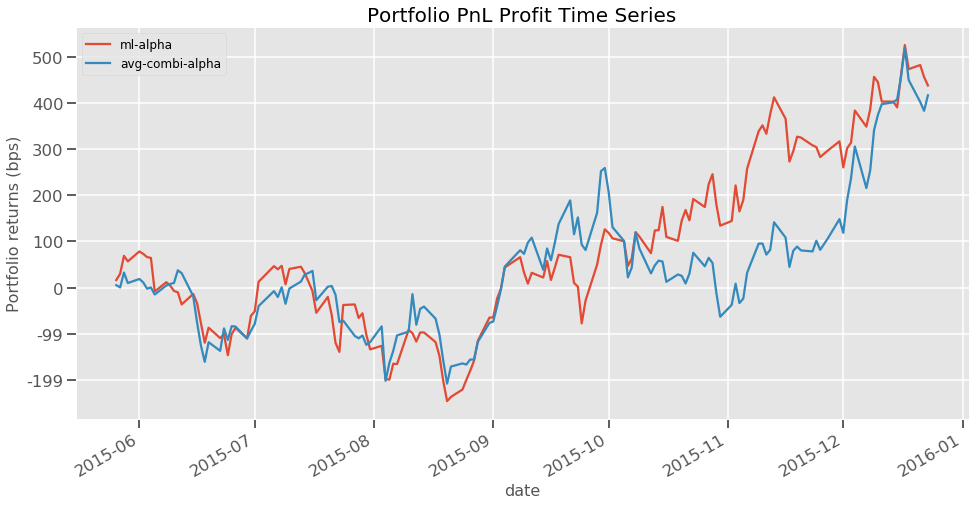

In [60]:
ax = pnl_tc_ml.plot(y='accum_total', label='ml-alpha')
pnl_tc_avg_combi.plot(ax=ax, y='accum_total', label='avg-combi-alpha')
ax.set_yticklabels([int(x) for x in ax.get_yticks()*1e4])
ax.set_ylabel("Portfolio returns (bps)")
plt.title("Portfolio PnL Profit Time Series")

plt.show()

In [61]:
alpha_attr = portopt_utils.compute_pnl_factor_attribution(E_factors_exp_df.filter(regex=r'^alpha'), f_factors_returns_df.filter(regex=r'^alpha'))

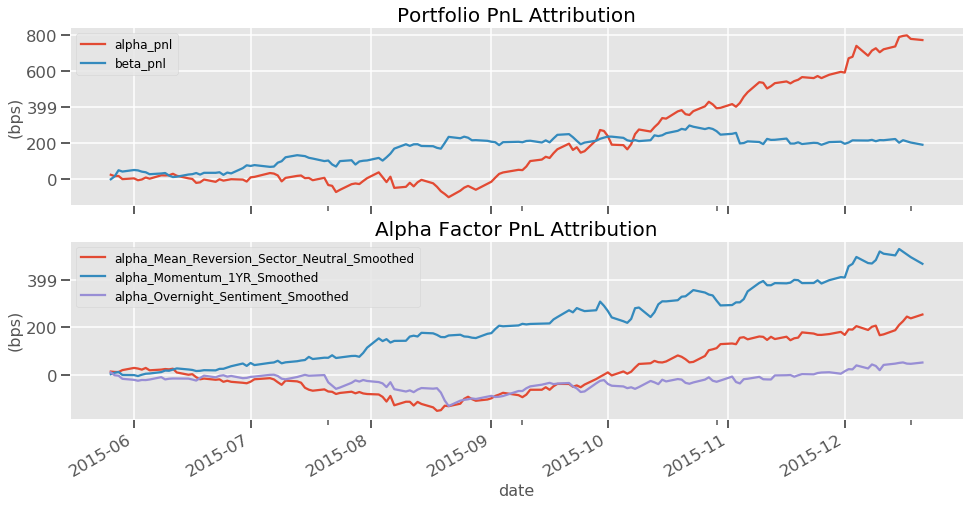

In [62]:
fig, axs = plt.subplots(2, 1, sharex=True)

ax1 = axs[0]
port_attr.plot(y=['alpha_pnl', 'beta_pnl'], ax=ax1)
ax1.set_title("Portfolio PnL Attribution")

ax2 = axs[1]
alpha_attr.plot(ax=ax2)
ax2.set_title("Alpha Factor PnL Attribution")

for ax in axs:
    ax.set_yticklabels([int(x) for x in ax.get_yticks()*1e4])
    ax.set_ylabel("(bps)")
plt.show()

## Sharpe Ratio

In [63]:
pnl_sharpe = pnl_app.groupby(level=1)['daily_total'].apply(lambda grp: portopt_utils.sharpe_ratio(grp, ann_period=252))
pnl_sharpe

port_name
simple_avg_combi    1.111504
simple_ml           1.224815
tc_avg_combi        1.113399
tc_ml               1.227569
Name: daily_total, dtype: float64

## Risk: Value-at-Risk

In [64]:
VaR95_emp = portopt_utils.compute_empirical_var(-pnl_tc_ml['daily_total'], 0.95)
VaR95_norm = portopt_utils.compute_theoretical_var(-pnl_tc_ml['daily_total'], 0.95)
VaR95_stu = portopt_utils.compute_theoretical_var(-pnl_tc_ml['daily_total'], 0.95, 'student')
VaR95_kdegauss = portopt_utils.compute_theoretical_var(-pnl_tc_ml['daily_total'], 0.95, 'gaussian_kde')
print(VaR95_emp, VaR95_norm, VaR95_stu, VaR95_kdegauss)

0.0056318145858661375 0.005952512566512626 0.007481780197315481 0.006347274556452755


In [65]:
cvar95_norm = portopt_utils.compute_cvar(-pnl_tc_ml['daily_total'], 0.95)
cvar95_stu = portopt_utils.compute_cvar(-pnl_tc_ml['daily_total'], 0.95, 'student')
print(cvar95_norm, cvar95_stu)

0.007539290148576524 0.01516332876563478


In [66]:
var_alpha_ml = -portopt_utils.compute_empirical_var(-pnl_tc_ml['daily_total'], 0.95)
var_avg_combi_ml = -portopt_utils.compute_empirical_var(-pnl_tc_avg_combi['daily_total'], 0.95)

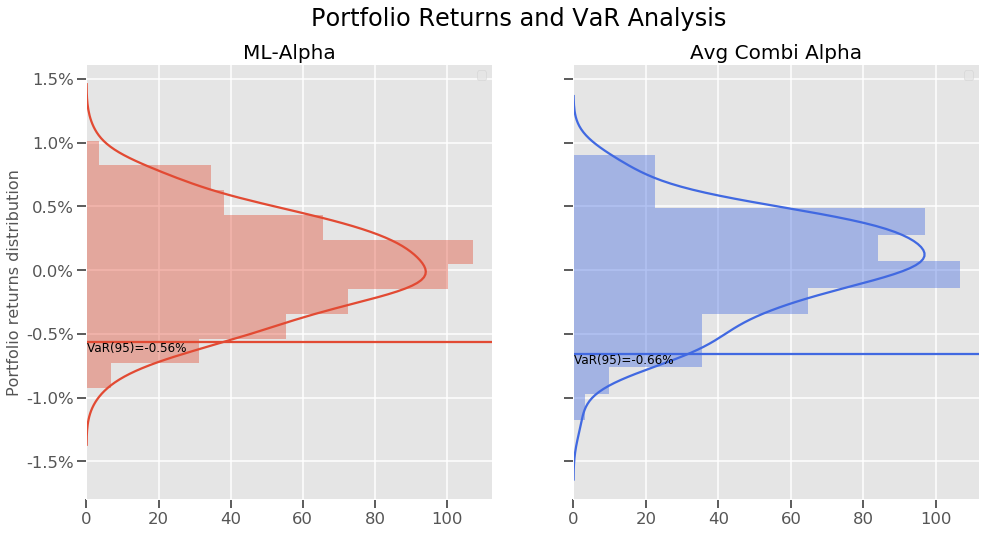

In [67]:
fig, axs = plt.subplots(1,2, sharey=True)

plt.suptitle('Portfolio Returns and VaR Analysis')

ax1 = axs[0]
sns.distplot(pnl_tc_ml['daily_total'], ax=ax1, norm_hist=True, vertical=True)

ax1.set_yticklabels([f'{x:0.2%}' for x in ax1.get_yticks()])
ax1.axhline(y=var_alpha_ml)
ax1.text(0, var_alpha_ml, f'VaR(95)={var_alpha_ml:0.2%}', va='top')

ax1.set_ylabel("Portfolio returns distribution")
ax1.set_title('ML-Alpha')

ax2 = axs[1]
sns.distplot(pnl_tc_avg_combi['daily_total'], ax=ax2, norm_hist=True, vertical=True, color='royalblue')

ax2.axhline(y=var_avg_combi_ml, color='royalblue')
ax2.text(0, var_avg_combi_ml, f'VaR(95)={var_avg_combi_ml:0.2%}', va='top')
ax2.set_ylabel('')
ax2.set_title('Avg Combi Alpha')

for ax in axs:
    ax.set_yticklabels([f'{x:0.1%}' for x in ax.get_yticks()])
    ax.legend("")
plt.show()

# Attribution

## Risk Factor Exposures

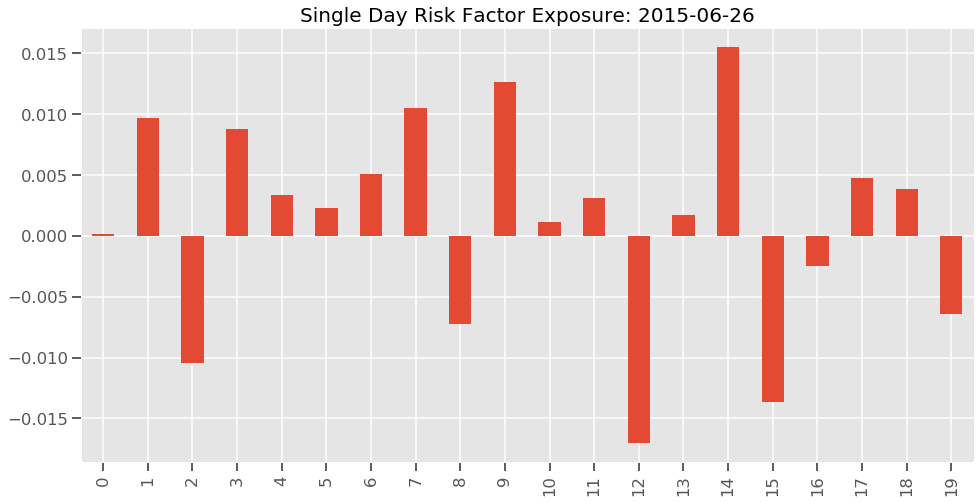

In [68]:
portopt_utils.get_factor_exposures(factor_betas=risk_model['factor_betas'], weights=tc_ml['20150526']).plot.bar()
plt.title('Single Day Risk Factor Exposure: 2015-06-26')
plt.show()

## Sector Performance

In [69]:
daily_sector_exp = pnl_and_w_df.groupby(['date', 'sector_code', 'sector', 'position'])['w_opt'].sum()

daily_sector_exp_long = daily_sector_exp.xs(level=3, key='1.long')
daily_sector_exp_short = daily_sector_exp.xs(level=3, key='2.short')

date_axis_long = daily_sector_exp_long.index.get_level_values(0).tz_localize(tz=None)
date_axis_short = daily_sector_exp_short.index.get_level_values(0).tz_localize(tz=None)

In [70]:
pnl_sector_perf = pnl_and_w_df.groupby('sector')[['w_opt', 'daily_asset_pnl']].agg(
    mean_w_opt=('w_opt', 'mean'),
    total_asset_pnl=('daily_asset_pnl', 'sum')
)
pnl_sector_perf

,mean_w_opt,total_asset_pnl
sector,,
Basic Materials,0.000971,0.007970
Communication Services,0.000797,-0.000834
Consumer Cyclical,-0.000159,0.001726
Consumer Defensive,-0.000193,-0.005694
Energy,0.000725,0.024317
Financial Services,0.000126,-0.014167
Healthcare,-0.000559,0.014174
Industrials,0.000001,-0.028972
No sector,-0.000531,0.002167


In [71]:
pnl_daily_sector_perf = pnl_and_w_df.reset_index(level='date').groupby(['date', 'sector'])[['w_opt', 'daily_asset_pnl']].agg(
    mean_w_opt=('w_opt', 'mean'),
    daily_sector_pnl=('daily_asset_pnl', 'sum'),
   )
pnl_daily_sector_perf['date'] = pnl_daily_sector_perf.index.get_level_values('date').tz_localize(tz=None)
pnl_daily_sector_perf['accum_sector_pnl'] = pnl_daily_sector_perf['daily_sector_pnl'].cumsum()


In [72]:
assert np.isclose(pnl_sector_perf.sum()['total_asset_pnl'], pnl_tc_ml['accum_total'].iloc[-1], atol=0.01) 

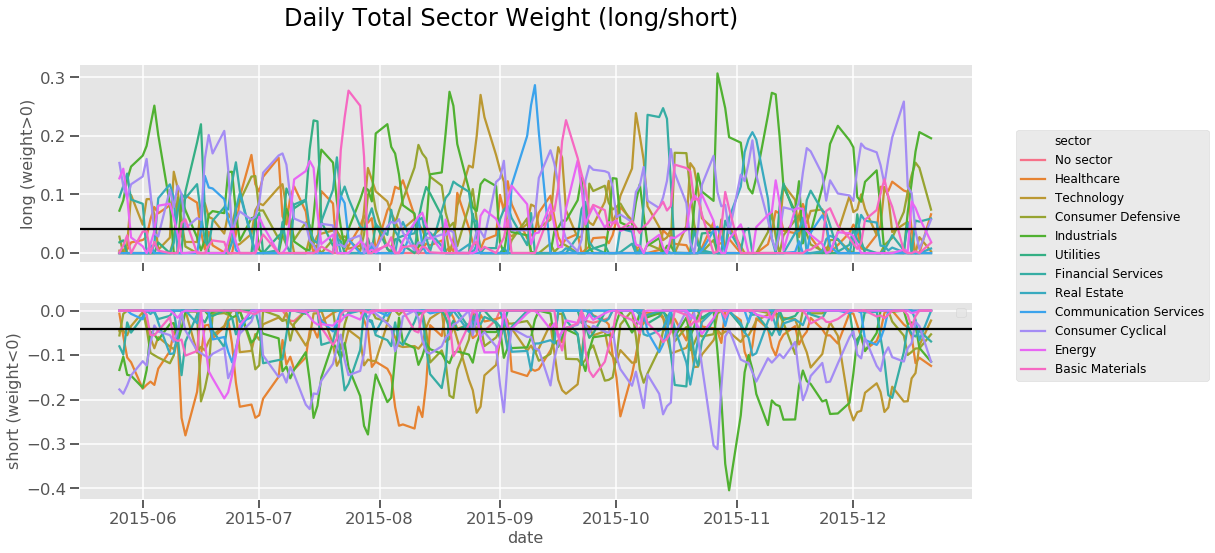

In [73]:
fig, axs = plt.subplots(2,1, sharex=True, sharey=False)

plt.suptitle("Daily Total Sector Weight (long/short)")

ax1 = axs[0]
sns.lineplot(ax=ax1, data=daily_sector_exp_long.reset_index(), x=date_axis_long, y="w_opt", hue="sector")
ax1.axhline(y=daily_sector_exp_long.mean(), color='black')
ax1.legend(loc=(1.05, -0.6))
ax1.set_ylabel('long (weight>0)')

ax2 = axs[1]
sns.lineplot(ax=ax2, data=daily_sector_exp_short.reset_index(), x=date_axis_short, y="w_opt", hue="sector")
ax2.axhline(y=daily_sector_exp_short.mean(), color='black')
ax2.set_ylabel('short (weight<0)')
ax2.legend("")


plt.show()

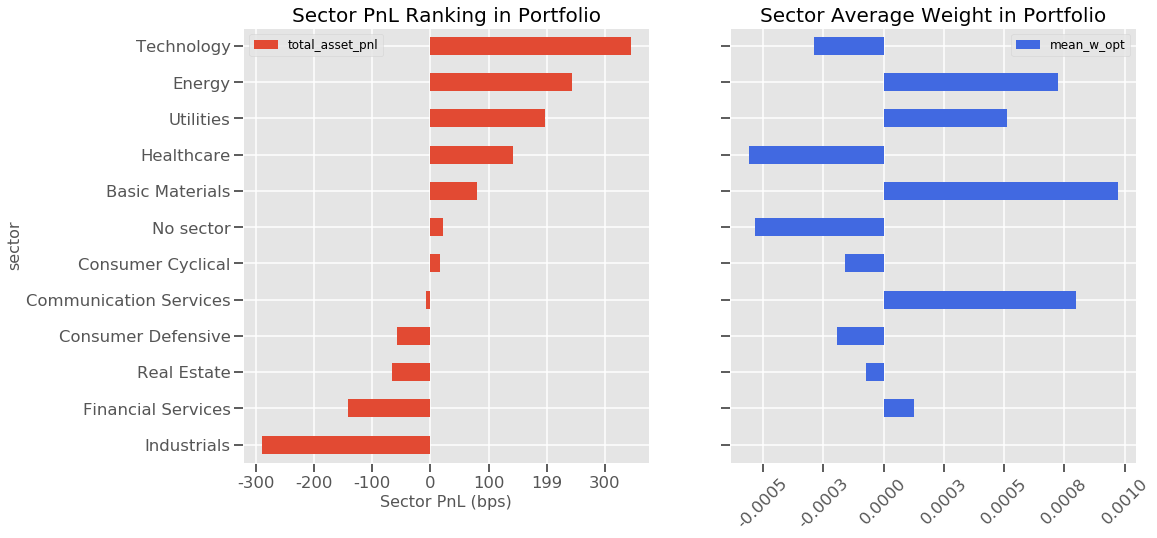

In [74]:
fig, axs = plt.subplots(1,2, sharey=True)

ax1 = axs[0]
pnl_sector_perf.sort_values(by='total_asset_pnl').plot.barh(ax=ax1, y='total_asset_pnl')
ax1.set_title('Sector PnL Ranking in Portfolio')
ax1.set_xticklabels([int(x) for x in ax1.get_xticks()*1e4])
ax1.set_xlabel("Sector PnL (bps)")

ax2 = axs[1]
pnl_sector_perf.sort_values(by='total_asset_pnl').plot.barh(ax=ax2, y='mean_w_opt', color='royalblue')
ax2.set_xticklabels([f'{x:0.4f}' for x in ax2.get_xticks()], rotation=45)
ax2.set_title('Sector Average Weight in Portfolio')

plt.show()

## Asset Performance

In [75]:
daily_asset_exp = pnl_and_w_df.groupby(['date', 'asset', 'position'])['w_opt'].sum()

In [76]:
pnl_asset_perf = pnl_and_w_df.groupby(level='asset')[['w_opt', 'daily_asset_pnl', 'sector']].agg(
    mean_w_opt=('w_opt', 'mean'),
    total_asset_pnl=('daily_asset_pnl', 'sum'),
    sector=('sector', 'last')).sort_values('total_asset_pnl', ascending=False)
pnl_asset_perf_top = pnl_asset_perf.sort_values(by='total_asset_pnl', ascending=False)[:25]
pnl_asset_perf_top.head(4)

,mean_w_opt,total_asset_pnl,sector
asset,,,
NBL,-0.003857,0.014787,Energy
PPG,0.007251,0.008452,Basic Materials
ETN,-0.008647,0.008073,Industrials
ADI,0.004033,0.007972,Technology


In [77]:
assert np.isclose(pnl_asset_perf.sum()['total_asset_pnl'], pnl_tc_ml['accum_total'].iloc[-1], atol=0.01) 

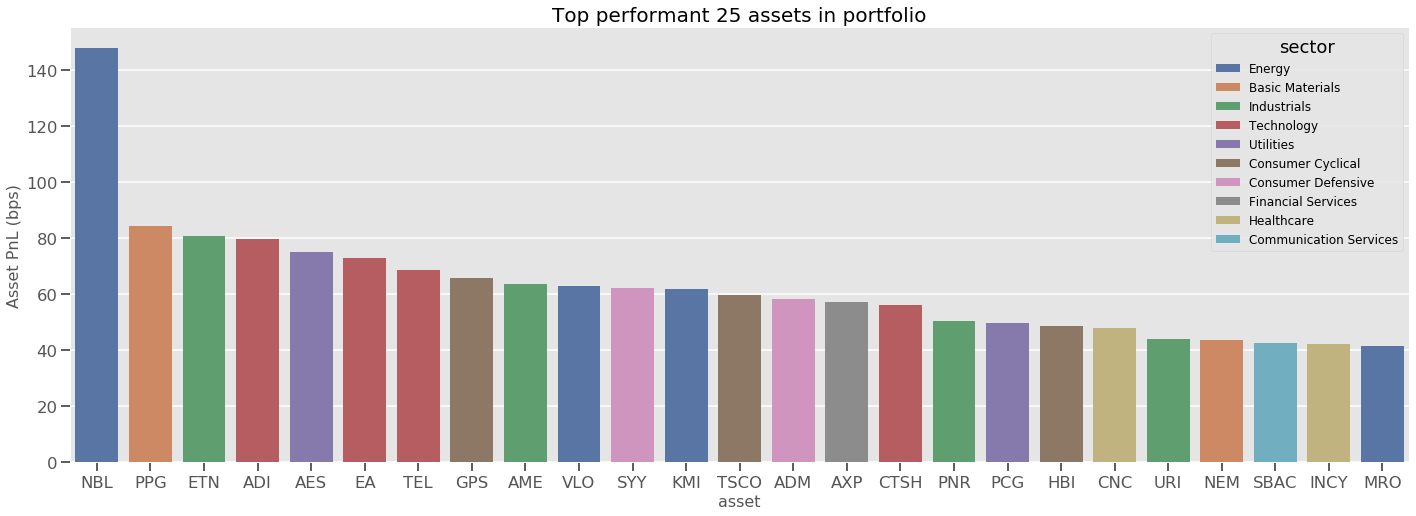

In [78]:
fig = plt.figure(figsize=(24,8))

ax = sns.barplot(data=pnl_asset_perf_top.reset_index()[:25], x='asset', y='total_asset_pnl', hue="sector", dodge=False, palette='deep')
plt.title('Top performant 25 assets in portfolio')
ax.set_yticklabels([int(x) for x in ax.get_yticks()*1e4])
ax.set_ylabel("Asset PnL (bps)")
plt.show()

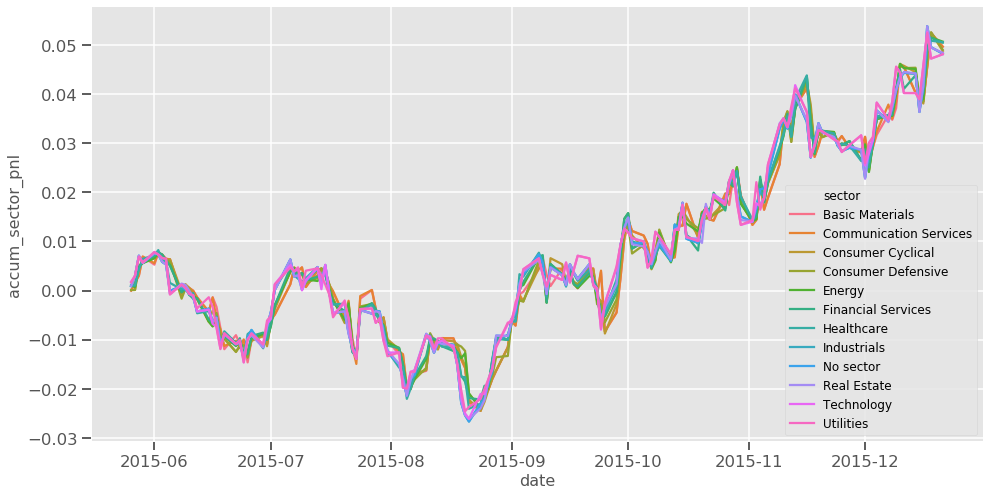

In [79]:
sns.lineplot(x=pnl_daily_sector_perf.index.get_level_values(0).tz_localize(tz=None),
             y=pnl_daily_sector_perf['accum_sector_pnl'], 
             hue=pnl_daily_sector_perf.index.get_level_values('sector')
            )
plt.show()

# Portfolio Holdings

one dolar Gross Market Value (GMV): $\sum|h_{i}|=1 \text{\$} $

long equals short: $\sum_{h{i}>0}h_{i} = \sum_{h{i}<0}|h_{i}|$

as a result:  $\sum_{h{i}>0}h_{i} = 0.5 \text{\$}\text{ and }  \sum_{h{i}<0}h_{i}=-0.5 \text{\$} $